# Tutorial: Calling germline variants in amplicon-based resequencing data

This tutorial is based on [De novo and inherited loss-of-function
variants in *TLK2*: identification, clinical delineation and
genotype-phenotype evaluation of a distinct neurodevelopmental disorder](https://www.sciencedirect.com/science/article/pii/S0002929718301617)
by MRF Reijnders, KA Miller et al.
The experimental data used here was generated by KA Miller.

After identifying a possibly pathogenic mutation in *TLK2*, we wanted to
screen a large cohort of patients for anybody else who carries a
mutation in that gene. We designed primers to capture exons 2-22 and
used a 384-sample paired-end kit to resequence 384 patients in a single
Illumina MiSeq run.

In this tutorial, we will look at how the data from this experiment was processed
using amplimap. We will be working with a subset of three samples, to speed
up processing times.

## Analysis overview

Starting from the raw sequencing reads, we would like to:

-  Trim off primer sequences
-  Align reads to the reference genome
-  Determine whether any target regions may have not been adequately
   covered in some of the samples
-  Call germline variants
-  Annotate variants with their consequences as well as allele
   frequencies and deleteriousness scores
-  Generate an overview table for manual inspection

## Initial setup

To run this tutorial amplimap needs to be installed and configured already.
Please see [Installation](https://amplimap.readthedocs.io/en/latest/installation.html)
and [Configuration](https://amplimap.readthedocs.io/en/latest/configuration.html) for details.

In particular, you need to have the hg19 (GRCh37) reference FASTA genome and the
associated indices prepared for use with your default aligner (see [Reference genome paths](https://amplimap.readthedocs.io/en/latest/configuration.html#reference-genome-paths)).

In addition, you need to have [Annovar installed and your indices set up](https://amplimap.readthedocs.io/en/latest/configuration.html#setting-up-annovar).

## Preparing the working directory


For every experiment that we want to process, we create a new working
directory. This will contain all the input files required, as well as
the output generated by amplimap. This makes it easy to keep track of
the data for each experiment, as well as to rerun analyses if required.

To create a directory, we use the standard ``mkdir`` unix command and
change into it with ``cd``:

    mkdir TLK2
    cd TLK2

All further commands should now be run inside this working directory.

### reads_in


The first input we need to provide to amplimap is of course the
sequencing data. These can be obtained directly from the sequencer as
``.fastq.gz`` files and should be placed in a directory called [``reads_in``](https://amplimap.readthedocs.io/en/latest/usage.html#reads-in).

[Download the sample data from this tutorial](http://userweb.molbiol.ox.ac.uk/public/koelling/amplimap/tutorial_data/TLK2.tar)
and extract the ``reads_in`` directory into your working directory. There are many different ways of doing this but
we recommend using ``wget`` and ``tar`` on the command line:

    wget http://userweb.molbiol.ox.ac.uk/public/koelling/amplimap/tutorial_data/TLK2.tar
    tar xf TLK2.tar

You can use ``ls`` to check that the files have been extracted to the correct subdirectory:

    ls reads_in

This should display a list of six fastq.gz files, which represent read 1
and read 2 of three samples:

    Sample1_L001_R1_001.fastq.gz  Sample1_L001_R2_001.fastq.gz
    Sample2_L001_R1_001.fastq.gz  Sample2_L001_R2_001.fastq.gz
    Sample3_L001_R1_001.fastq.gz  Sample3_L001_R2_001.fastq.gz



### probes.csv

Next, we need to provide a [probes.csv file](https://amplimap.readthedocs.io/en/latest/usage.html#probes-csv) that describes the used
primer sequences and the regions they are supposed to capture. This can
be created with spreadsheet software such as Excel, as long as the file is
saved as plain text. However, we recommend always checking the file manually
using a plain text editor such as ``nano`` or ``vim``, to make sure it is actually in the right
format.

Create a new plain text file called ``probes.csv`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    id,first_primer_5to3,second_primer_5to3,chr,target_start,target_end,strand
    TLK2-Ex2,AATTACTGTGAGTTTTGTTCTACAG,ACTATGTTAAATGACTACTGGAATGACC,chr17,60558422,60558714,+
    TLK2-Ex3,ACGCCATTGTATTCCAGCCGGGGTGAT,CAGCCTTGAGCCACCAAACCTGGCCCAAAC,chr17,60598019,60598245,+
    TLK2-Ex4,TAAGAGGAAGACAGTGATTCAGGAC,GAACTAACACTGTTCTGTCAGGTG,chr17,60599449,60599800,+
    TLK2-Ex5,TGGAGGAAATAGTCTGTTCTTG,ATGTTGCCCAGGTTGGCCTCGAACT,chr17,60600344,60600732,+
    TLK2-Ex6,GCATAGTACTGTTTTGAATTATTCATATCG,CTCTTCTGTAAAAAGCTAATTTACTGAC,chr17,60601577,60601855,+
    TLK2-Ex7,CTTATATTTGATAACTGTTTTTAACCCG,GAGCACTAGGGCAATGGAAAGGATA,chr17,60613463,60613723,+
    TLK2-Ex8,GAACTTGGTATAAACCACCATGTCC,GTGGTCAGAGAAATACAGAGAAGTC,chr17,60629478,60629842,+
    TLK2-Ex9,ATTTGTGTGAGCAAGTGCTTTTTCC,GGTGCTTGCTATAAAATCTCTTACA,chr17,60630934,60631128,+
    TLK2-Ex10,AAACATGCCCAAATTAGTAATTCAA,CAAATCATGTTCCTAAAAAGCTCTAC,chr17,60637164,60637585,+
    TLK2-Ex11,TTCTAAGAAGTGTCTTTATCCATGC,AGGACTTCACCTCATTCGATAC,chr17,60642320,60642640,+
    TLK2-Ex12,AAATTGGATACACAAGTGACAAATTG,CTATTGCCGGTGACAATCAAC,chr17,60650431,60650833,+
    TLK2-Ex13,GCTTTGAAGTTCTTCCCTCACATC,CACTGAAGCTTTCTGCTGCTATG,chr17,60653891,60654235,+
    TLK2-Ex14,TTACTGAACTCCTCTGTATGGTTTG,AGCAATCTCCAACCCAATATGC,chr17,60655659,60655949,+
    TLK2-Ex15,CTGGGAATTTTGCAAGCGTGG,TATGAGGCAGGAAGTACAGAACC,chr17,60657421,60657827,+
    TLK2-Ex16,TAATCACAAGTTTCAAGAAGGTGCT,ACCAACAACAATGCACGTAAAG,chr17,60663354,60663656,+
    TLK2-Ex17,TCTCAATGGCTTGGTAGATTCC,TGTCACAAATTACTTGGTTCCCTC,chr17,60673772,60674134,+
    TLK2-Ex18,AGGTAGTGTTAATCTGCTTGCTC,TCCAACACGCCCTCCTAAAC,chr17,60677974,60678351,+
    TLK2-Ex19,AGTCCAGATTGCTTGATTCCC,GCCACATCTCTATAGCCAACCTG,chr17,60679277,60679561,+
    TLK2-Ex20,GTACATGTCTTAAACTTATATGATC,CCTAGGGTTGAGGATTTCTGCT,chr17,60683454,60683774,+
    TLK2-Ex21,CCCACTCTGCTTTGACCTGGTAG,TTCACACTGAAGAATCCATCCA,chr17,60685195,60685580,+
    TLK2-Ex22,AGAGGTACTTCTGTTGGTGCTT,GGATTCGCTATGTTCCAAACC,chr17,60689581,60690988,+

### targets.csv

We also want to describe the target regions that amplimap
should analyse in the [targets.csv](https://amplimap.readthedocs.io/en/latest/usage.html#targets-csv) file. This helps speed up the
process, since any reads outside the targets can be ignored. It also
allows us to calculate the average coverage for each target in each
sample.

Create a new plain text file called ``targets.csv`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    chr,start,end,id
    chr17,60558422,60558714,TLK2-Ex2
    chr17,60598019,60598245,TLK2-Ex3
    chr17,60599449,60599800,TLK2-Ex4
    chr17,60600344,60600732,TLK2-Ex5
    chr17,60601577,60601855,TLK2-Ex6
    chr17,60613463,60613723,TLK2-Ex7
    chr17,60629478,60629842,TLK2-Ex8
    chr17,60630934,60631128,TLK2-Ex9
    chr17,60637164,60637585,TLK2-Ex10
    chr17,60642320,60642640,TLK2-Ex11
    chr17,60650508,60650785,TLK2-Ex12
    chr17,60653891,60654235,TLK2-Ex13
    chr17,60655659,60655949,TLK2-Ex14
    chr17,60657421,60657827,TLK2-Ex15
    chr17,60663354,60663656,TLK2-Ex16
    chr17,60673772,60674134,TLK2-Ex17
    chr17,60677974,60678351,TLK2-Ex18
    chr17,60679277,60679561,TLK2-Ex19
    chr17,60683454,60683774,TLK2-Ex20
    chr17,60685195,60685580,TLK2-Ex21
    chr17,60689581,60689989,TLK2-Ex22

### config.yaml

Finally, we create a config.yaml file to set some experiment-specific settings.
We could set [a lot more options](https://amplimap.readthedocs.io/en/latest/configuration.html)
here but in this case set a few of them. All other options will be left
as specified in the default configuration.

Create a new plain text file called ``config.yaml`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    general:
      genome_name: "hg19"

This tells amplimap to use the reference genome ``hg19``, as specified in your
[default configuration](https://amplimap.readthedocs.io/en/latest/configuration.html#default-configuration).
If you do not have this reference genome set up there, you can also specify the necessary paths directly
in the ``config.yaml`` by adding the following additional lines and editing the paths to match your local setup:

    paths:
      hg19:
        bwa: "/INSERT/PATH/TO/PREFIX"
        fasta: "/INSERT/PATH/TO/FASTA"
        annovar: "/INSERT/PATH/TO/ANNOVAR/INDICES"
        
For ``bwa`` you would provide the path of the prefix you used when [building the BWA index](http://bio-bwa.sourceforge.net/bwa.shtml#3).
If you are using Bowtie2 as your aligner you can replace ``bwa`` with ``bowtie2`` in the config file and provide the prefix of its index files instead.
For ``fasta`` you would provide the path to the corresponding FASTA file, which needs to have been indexed with ``samtools faidx``.
Finally, you need to provide the path to your Annovar index directory under ``annovar``.

## Running amplimap

Now we can run amplimap. In our case, we want to obtain coverage values
(“coverages”) and annotated variant calls (“variants”). This will also
automatically run the other parts of the pipeline that are required,
such as trimming the primers and aligning reads to the genome.
First we will do a dry-run to confirm that all input files can be found:

    amplimap coverages variants
    
This should output a long list of commands, ending with these lines:

    Job counts:
        count   jobs
        3       align_pe
        3       annotate_variants
        3       calc_coverage
        3       call_variants_raw
        1       convert_targets_csv
        1       copy_probes
        1       coverage_agg
        3       coverage_process
        1       coverages
        6       link_reads
        1       merge_targets
        3       parse_reads_pe
        1       start_analysis
        3       stats_alignment
        1       stats_alignment_agg
        1       stats_reads_agg
        1       stats_samples_agg
        6       tool_version
        1       variants
        1       variants_merge
        1       variants_summary
        1       variants_summary_condensed
        46

    amplimap dry run successful. Set --run to run!
    
You can see how amplimap is planning to run 3 alignment jobs (align_pe) and 3 variant calling jobs (call_variants),
corresponding to the 3 samples we are analysing.

Having confirmed that everything looks as expected, we can run amplimap:

    amplimap coverages variants --run

This will take a few minutes to complete. It would be much faster if we
ran jobs in parallel (for example using a cluster), but we are not
doing that for the purposes of this tutorial.

## Analysing the results

amplimap has now processed our reads, aligned them to the reference genome, called germline variants, annotated them
and produced a summary table with the variant calls.
All of the output files have been placed into the ``analysis`` directory.

Let's explore some of the output. Most analyses in amplimap produce one or more CSV file with a table of results. In this tutorial, we will use Python and pandas to process and visualize these files. However, the same thing could also be done in R or Excel.

### analysis/reads_parsed/

This directory contains results from the first step of the pipeline which
identified primer arms in reads, trimmed them off and calculated some
run statistics.

For example, the ``stats_samples.csv`` file tells us about the number of reads in each sample and how many of these contained the expected primer sequences:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.read_csv('analysis/reads_parsed/stats_samples.csv')

,sample,files,pairs_total,pairs_unknown_arms,pairs_good_arms,pairs_r1_too_short,pairs_r2_too_short
0,Sample1,1,29218,2962,26256,0,0
1,Sample2,1,6887,859,6028,0,0
2,Sample3,1,19476,1918,17558,0,0


And for a more detailed look at the number of reads observed per probe in each sample, there is ``stats_reads.csv``:

In [2]:
pd.read_csv('analysis/reads_parsed/stats_reads.csv').head()

,sample,probe,read_pairs
0,Sample1,TLK2-Ex10,130
1,Sample1,TLK2-Ex11,719
2,Sample1,TLK2-Ex12,3675
3,Sample1,TLK2-Ex13,1152
4,Sample1,TLK2-Ex14,616


This table already gives us an idea of how well we covered each of the exons in each of the samples. However, the more accurate way of looking at this is through the coverage tables:

### analysis/bams/coverages/

This directory contains the coverage information for each sample and each target.
The most comprehensive table to look at is ``coverages_long.csv``. In addition,
there are also various aggregate tables that, for example, tell you the minimum coverage in each target and
each sample (``min_coverage.csv``) or what fraction of the target was not covered by any reads (``fraction_zero_coverage.csv``).

Let's load the ``fraction_zero_coverage.csv`` file and visualize the zero coverage fractions:

Text(0.5,1,'Fraction of exon with no coverage')

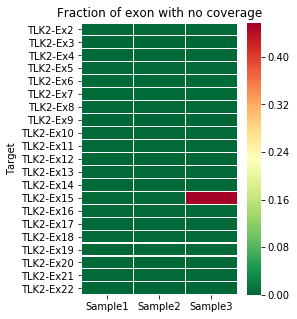

In [3]:
zero_fraction = pd.read_csv('analysis/bams/coverages/fraction_zero_coverage.csv', index_col='Target')

#reorder by exon number
zero_fraction['sort_key'] = zero_fraction.index.str.replace('TLK2-Ex', '').astype(int)
zero_fraction = zero_fraction.sort_values('sort_key').drop(columns=['sort_key'])

plt.figure(figsize=(3.5, 5))
sns.heatmap(zero_fraction, cmap='RdYlGn_r', linewidths=0.1)
plt.title("Fraction of exon with no coverage")

We can clearly see that there is one exon that had very low coverage in one of the targets. To list all targets with less than 95% coverage in at least one sample, we can use this:

In [4]:
zero_fraction[zero_fraction.apply(max, axis = 1) > 0.05]

,Sample1,Sample2,Sample3
Target,,,
TLK2-Ex15,0.002457,0.002457,0.457002


In this case, almost half of exon 15 (45.7%) was not covered at all in sample 3. We might want to try sequencing this sample again to make sure we didn't miss any mutations in this exon. Otherwise, most exons seem to have been covered quite well in all samples, as indicated by the average coverage shown in the ``cov_per_bp.csv`` table:

In [5]:
cov_per_bp = pd.read_csv('analysis/bams/coverages/cov_per_bp.csv', index_col='Target')
cov_per_bp.head()

,Sample1,Sample2,Sample3
Target,,,
TLK2-Ex10,140.907583,29.992891,9.767773
TLK2-Ex11,1034.809969,245.526480,1259.570093
TLK2-Ex12,6126.651079,1915.147482,5215.931655
TLK2-Ex13,1542.437681,282.860870,1395.542029
TLK2-Ex14,979.910653,273.639175,909.109966


The average coverage for exon 10 was only around 10x in sample 3, but apart from exon 10 and 15 all other exons were covered to at least ~70x in all samples.

In [6]:
cov_per_bp.apply(min, axis=1)

Target
TLK2-Ex10       9.767773
TLK2-Ex11     245.526480
TLK2-Ex12    1915.147482
TLK2-Ex13     282.860870
TLK2-Ex14     273.639175
TLK2-Ex15       0.597052
TLK2-Ex16      69.904290
TLK2-Ex17     254.435262
TLK2-Ex18     234.023810
TLK2-Ex19     302.389474
TLK2-Ex2      611.010239
TLK2-Ex20    1096.919003
TLK2-Ex21     102.580311
TLK2-Ex22     285.767726
TLK2-Ex3      353.383260
TLK2-Ex4      136.312500
TLK2-Ex5       84.308483
TLK2-Ex6      222.559140
TLK2-Ex7     1532.881226
TLK2-Ex8      207.038356
TLK2-Ex9      189.302564
dtype: float64

### analysis/variants_raw/

Here we can find the final output of the germline variant calling -
the annotated table of variants. The ``variants_summary.csv``
table includes all the information one would usually find in a VCF
file (chromosome, position, ref, alt, genotype, allele fraction, quality),
as well as various annotations from Annovar regarding the functional
impact and deleteriousness of the variant. There is also information
about the frequency of the variant in reference sets, such as 1000 Genomes,
gnomAD or ExAC.

There will be one line per sample and variant, so the same variant can appear
in multiple lines.

Let's have a look at a few examples:

In [7]:
variants = pd.read_csv('analysis/variants_raw/variants_summary.csv')

#fill empty cells
variants.fillna(value={'Var_FailedFilters': '', 'ExonicFunc.refGene': '', 'ExAC_ALL': 0, 'gnomAD_genome_ALL': 0, 'CADD_phred': 0}, inplace=True)

#extract columns
variants = variants[ ['Sample', 'Target', 'Var_Zygosity', 'Var_AltFraction', 'Var_FailedFilters', 'Func.refGene', 'ExonicFunc.refGene', 'ExAC_ALL', 'gnomAD_genome_ALL', 'CADD_phred', 'Chr', 'Start', 'Ref', 'Alt'] ]


variants.head()

,Sample,Target,Var_Zygosity,Var_AltFraction,Var_FailedFilters,Func.refGene,ExonicFunc.refGene,ExAC_ALL,gnomAD_genome_ALL,CADD_phred,Chr,Start,Ref,Alt
0,Sample1,TLK2-Ex3,Het,0.301471,,intronic,,0.0000,0.0003,0.0,chr17,60598038,AAA,-
1,Sample1,TLK2-Ex4,HOM,1.000000,,intronic,,0.0000,0.9611,0.0,chr17,60599797,G,A
2,Sample1,TLK2-Ex5,Het,0.507042,,intronic,,0.0000,0.0952,0.0,chr17,60600729,C,G
3,Sample1,TLK2-Ex10,Het,0.489796,,intronic,,0.0000,0.1359,0.0,chr17,60637258,C,A
4,Sample1,TLK2-Ex20,HOM,1.000000,,exonic,synonymous SNV,0.5926,0.5195,0.0,chr17,60683503,A,G


In total we found 21 variants:

In [8]:
print(len(variants))

21


Many of these variants seem to appear at high frequencies in the general population, as indicated by the ExAC and gnomAD frequencies. We expect pathogenic mutations in this gene to have full penetrance and know that the disease should be rare, so anything above 1% allele frequency is clearly not of interest. Thus, we filter out common variants:

In [9]:
variants[ (variants['Var_FailedFilters'] == '') & (variants['ExAC_ALL'] < 0.01) & (variants['gnomAD_genome_ALL'] < 0.01) ]

,Sample,Target,Var_Zygosity,Var_AltFraction,Var_FailedFilters,Func.refGene,ExonicFunc.refGene,ExAC_ALL,gnomAD_genome_ALL,CADD_phred,Chr,Start,Ref,Alt
0,Sample1,TLK2-Ex3,Het,0.301471,,intronic,,0.0,0.0003,0.0,chr17,60598038,AAA,-
6,Sample2,TLK2-Ex2,Het,0.125000,,intronic,,0.0,0.0000,0.0,chr17,60558639,A,G
10,Sample2,TLK2-Ex12,Het,0.200000,,exonic,stopgain,0.0,0.0000,39.0,chr17,60650596,C,A
14,Sample3,TLK2-Ex3,Het,0.324138,,intronic,,0.0,0.0003,0.0,chr17,60598038,AAA,-
16,Sample3,TLK2-Ex5,Het,0.083333,,intronic,,0.0,0.0000,0.0,chr17,60600706,A,G
18,Sample3,TLK2-Ex5,Het,0.083333,,intronic,,0.0,0.0000,0.0,chr17,60600731,T,G


We can see some intronic variant calls that do not very convincing, including one in two unrelated samples. This suggests that this is likely to be either a common polymorphism or a recurrent variant calling error. We might want to filter variants like this out by setting stricter filters, for example on the allele frequency (eg. <0.1%), the alt allele fraction (eg. > 15%) or directly on the number of samples in our screen that carried that mutation (eg. < 3).

However, we also found one novel variant in sample 2 that looks very interesting: a stopgain mutation in exon 12 that has never been observed in ExAC or gnomAD, and which is predicted to be highly deleterious by CADD with a score of 39. This would certainly warrant further investigation.

# Appendix

In [10]:
#simple overview table:
variants['ID'] = variants['Sample'].str.replace('Sample', '')
variants['gnomAD'] = variants['gnomAD_genome_ALL'] * 100.0
variants.rename(columns={'ExonicFunc.refGene': 'Impact', 'CADD_phred': 'CADD'}).loc[
    (variants['Var_FailedFilters'] == '') & (variants['Func.refGene'] != 'intronic'),
    ['ID', 'Target', 'Ref', 'Alt', 'Impact', 'CADD', 'gnomAD']
]

,ID,Target,Ref,Alt,Impact,CADD,gnomAD
4,1,TLK2-Ex20,A,G,synonymous SNV,0.0,51.95
10,2,TLK2-Ex12,C,A,stopgain,39.0,0.00
12,2,TLK2-Ex20,A,G,synonymous SNV,0.0,51.95
19,3,TLK2-Ex20,A,G,synonymous SNV,0.0,51.95


Text(43.4167,0.5,'')

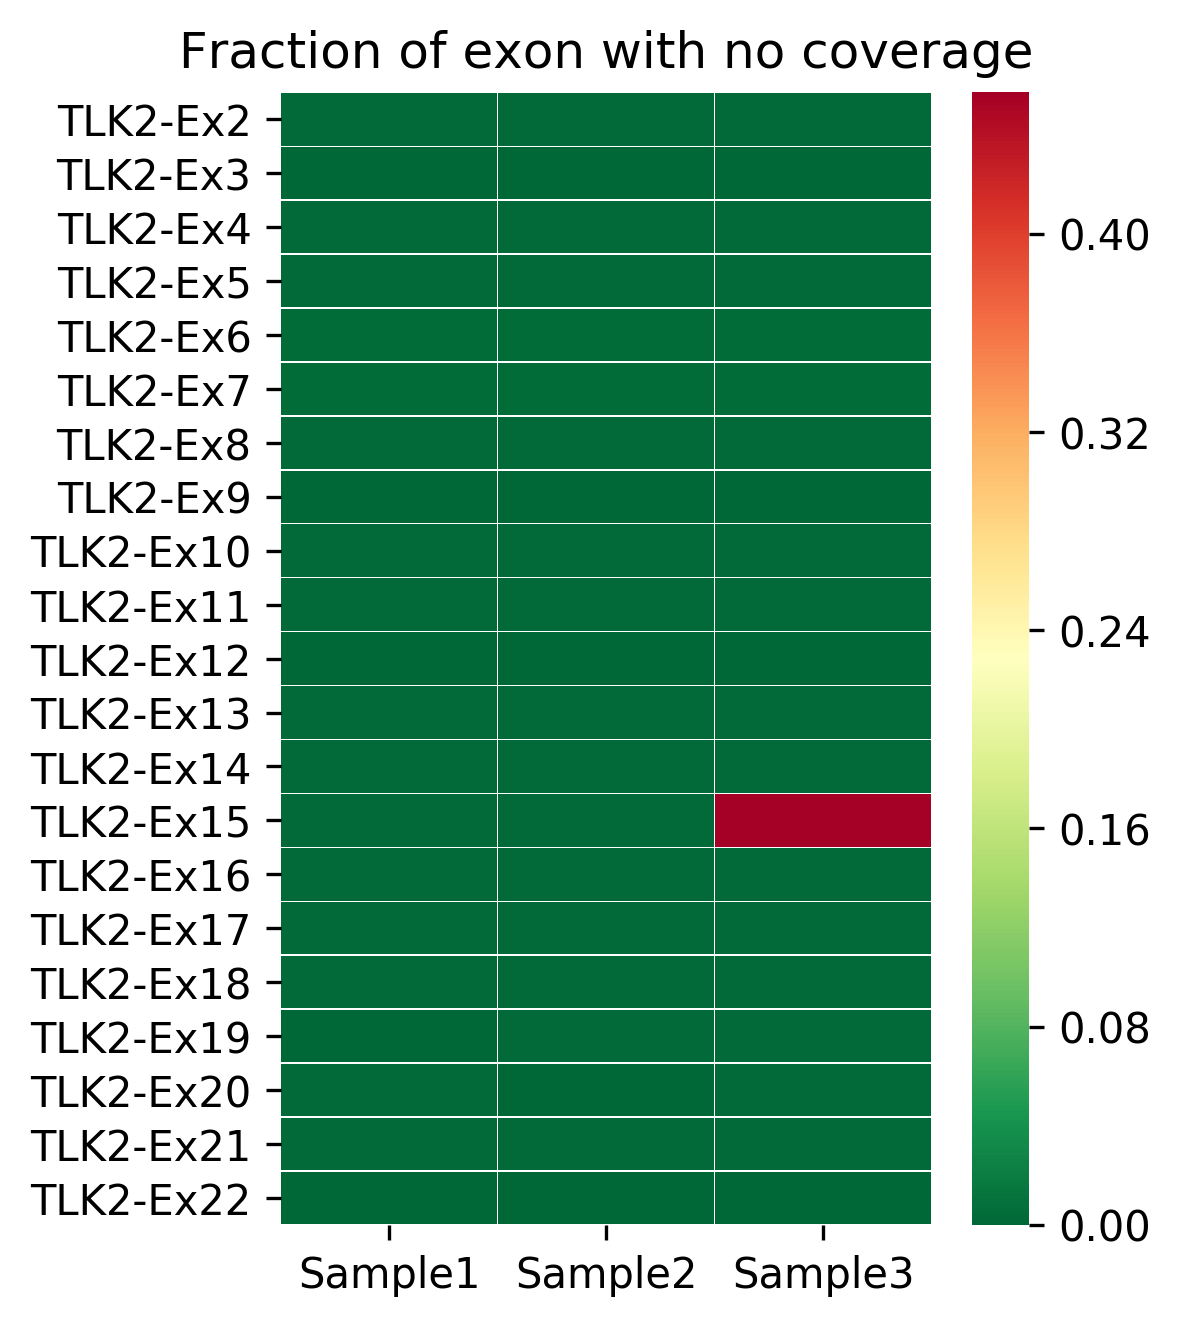

In [11]:
#additional figures in high-res
plt.figure(figsize=(3.5, 5), dpi=300)
sns.heatmap(zero_fraction, cmap='RdYlGn_r', linewidths=0.1)
plt.title("Fraction of exon with no coverage")
plt.ylabel("")

In [12]:
sns.set_style("ticks")

Text(0,0.5,'')

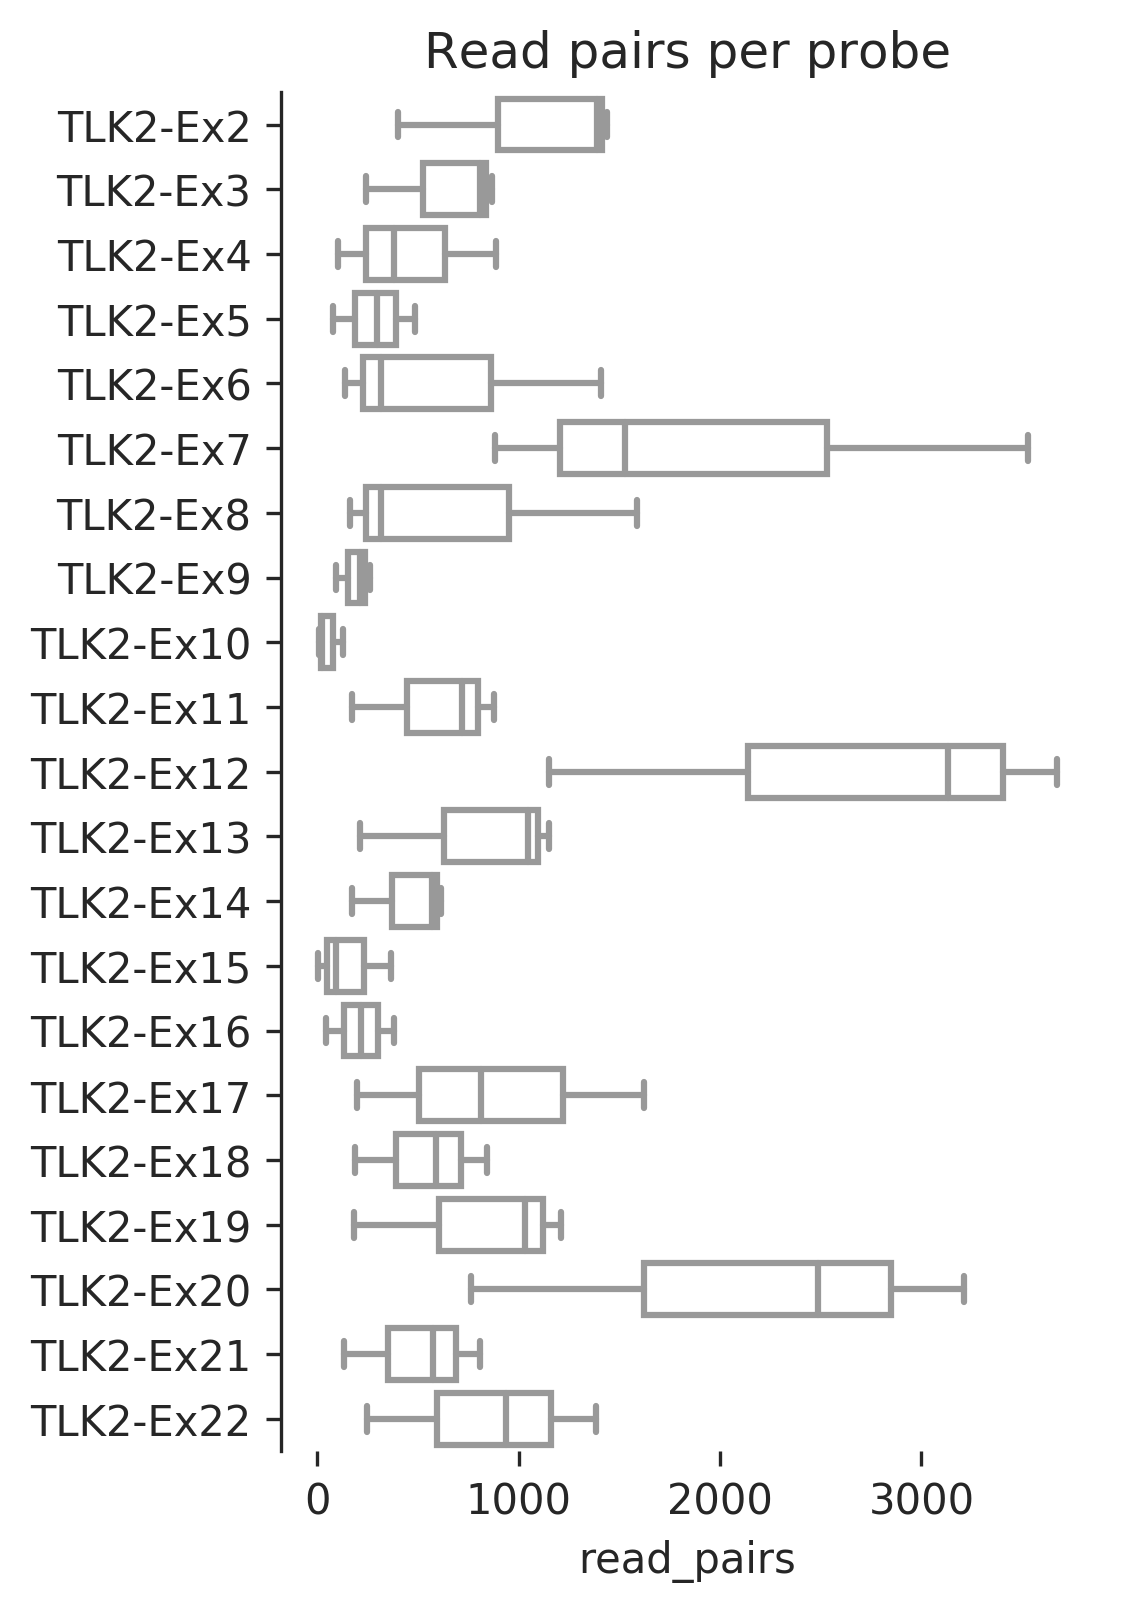

In [13]:
#read stats
stats_reads = pd.read_csv('analysis/reads_parsed/stats_reads.csv')

#reorder by exon number
stats_reads['sort_key'] = stats_reads['probe'].str.replace('TLK2-Ex', '').astype(int)
stats_reads = stats_reads.sort_values('sort_key').drop(columns=['sort_key'])

plt.figure(figsize=(3.5, 6), dpi=300)
sns.boxplot(y='probe', x='read_pairs', color='white', data=stats_reads, orient='h')
sns.despine(bottom=True)
plt.title("Read pairs per probe")
plt.ylabel("")

In [14]:
!amplimap --version
!grep '_amplimap' analysis/versions.yaml

amplimap 0.4.4
_amplimap: 0.4.4
